# About the problem
    The problem chosen is to predict the outcome of an Starcraft match being the outcome whether 
    player 1 is the winner or not.
# About the dataset
    The dataset contains 374793 rows and 10 columns
## Features
    match_date            : Date of match in format mm/dd/yyyy
    player_1              : Player 1 Nickname
    player_1_match_status : Match status for Player 1: winner or loser
    score                 : match score (example: 1-0, 1-2 etc)
    player_2              : Player 2 Nickname
    player_2_match_status : Match status for Player 2: winner or loser
    player_1_race         : Player 1 Race: Z - Zerg, P - Protoss, T - Terran
    player_2_race         : Player 2 Race: Z - Zerg, P - Protoss, T - Terran
    addon                 : WoL- Wings of Liberty, HotS - Heart of the Swarm, LotV - Legacy of the Void
    tournament_type       : online or offline

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#modelos para calculo#
from sklearn import metrics as mt, preprocessing as pp, ensemble
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('dataset/sc2-matches-history.csv', header=0)

In [3]:
data.head()

,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
0,09/19/2016,MC,[loser],0–2,Stats,[winner],P,P,LotV,online
1,09/19/2016,MC,[winner],2–1,NaTuRal,[loser],P,T,LotV,online
2,09/19/2016,MC,[loser],1–2,Dark,[winner],P,Z,LotV,online
3,09/13/2016,MC,[loser],0–2,INnoVation,[winner],P,T,LotV,online
4,08/27/2016,MC,[loser],0–1,TRUE,[winner],P,Z,LotV,online


# What to do?
    - match_date           : apply feature extraction
    - player_1             : unique id
    - player_1_match_status: binary
    - score                : this feature is not going to be used.
    - player_2             : unique id
    - player_2_match_status: this feature is not going to be used.
    - player_1_race        : apply one hot encoding
    - player_2_race        : apply one hot encoding
    - addon                : apply one hot encoding
    - tournament_type      : binary

## drop null rows

In [4]:
data.isnull().sum()

match_date               0
player_1                 0
player_1_match_status    0
score                    0
player_2                 1
player_2_match_status    0
player_1_race            0
player_2_race            0
addon                    0
tournament_type          0
dtype: int64

In [5]:
data = data.dropna(axis=0)

In [6]:
data.isnull().sum()

match_date               0
player_1                 0
player_1_match_status    0
score                    0
player_2                 0
player_2_match_status    0
player_1_race            0
player_2_race            0
addon                    0
tournament_type          0
dtype: int64

## Preprocessing data

### Adding column 'day_of_week' based on 'match_date' and dropping 'match_date' and 'score'

In [7]:
#Transformar match_date em dia da semana
data['match_date'] = pd.to_datetime(data['match_date'])
data['day_of_week'] = data['match_date'].dt.weekday_name

In [8]:
data = data.drop(columns='match_date', axis=1)
data = data.drop(columns='score', axis=1)

In [9]:
data.head()

,player_1,player_1_match_status,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type,day_of_week
0,MC,[loser],Stats,[winner],P,P,LotV,online,Monday
1,MC,[winner],NaTuRal,[loser],P,T,LotV,online,Monday
2,MC,[loser],Dark,[winner],P,Z,LotV,online,Monday
3,MC,[loser],INnoVation,[winner],P,T,LotV,online,Tuesday
4,MC,[loser],TRUE,[winner],P,Z,LotV,online,Saturday


### Transforming 'player_1_match_status' and 'tournament_type' into binary and dropping 'player_2_match_status'

In [10]:
transform_p1_match_status = {label: idx for idx, label in enumerate(np.unique(data['player_1_match_status']))}
data['player_1_match_status'] = data['player_1_match_status'].map(transform_p1_match_status)

In [11]:
transform_tournament_type = {label: idx for idx, label in enumerate(np.unique(data['tournament_type']))}
data['tournament_type'] = data['tournament_type'].map(transform_tournament_type)

In [12]:
data = data.drop(['player_2_match_status'], axis=1)

In [13]:
data.head()

,player_1,player_1_match_status,player_2,player_1_race,player_2_race,addon,tournament_type,day_of_week
0,MC,0,Stats,P,P,LotV,1,Monday
1,MC,1,NaTuRal,P,T,LotV,1,Monday
2,MC,0,Dark,P,Z,LotV,1,Monday
3,MC,0,INnoVation,P,T,LotV,1,Tuesday
4,MC,0,TRUE,P,Z,LotV,1,Saturday


### Transforming "player_1" and "player_2" columns into unique numbers

In [14]:
#transform_players = {label: idx for idx, label in enumerate(np.unique(data['player_2']))}
#transform_players

transform_players = {label: idx for idx, label in enumerate(np.unique(data[['player_1', 'player_2']].values))}
data['player_1'] = data['player_1'].map(transform_players)
data['player_2'] = data['player_2'].map(transform_players)

In [15]:
data.isnull().sum()

player_1                 0
player_1_match_status    0
player_2                 0
player_1_race            0
player_2_race            0
addon                    0
tournament_type          0
day_of_week              0
dtype: int64

In [16]:
data.head()

,player_1,player_1_match_status,player_2,player_1_race,player_2_race,addon,tournament_type,day_of_week
0,4450,0,7328,P,P,LotV,1,Monday
1,4450,1,5125,P,T,LotV,1,Monday
2,4450,0,1575,P,Z,LotV,1,Monday
3,4450,0,3270,P,T,LotV,1,Tuesday
4,4450,0,7548,P,Z,LotV,1,Saturday


### One Hot Enconding with Pandas

In [17]:
data = pd.get_dummies(data[['player_1', 'player_1_match_status', 'player_2', 'player_1_race', 'player_2_race', 'addon', 'tournament_type', 'day_of_week']], drop_first=True)

In [18]:
data.head()

,player_1,player_1_match_status,player_2,tournament_type,player_1_race_R,player_1_race_T,player_1_race_Z,player_2_race_R,player_2_race_T,player_2_race_Z,addon_LotV,addon_WoL,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,4450,0,7328,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,4450,1,5125,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0
2,4450,0,1575,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0
3,4450,0,3270,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,4450,0,7548,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0


### Rearranging columns

In [19]:
#cols = data.columns.tolist()
data = data[['player_1',
             'player_2',
             'tournament_type',
             'player_1_race_R',
             'player_1_race_T',
             'player_1_race_Z',
             'player_2_race_R',
             'player_2_race_T',
             'player_2_race_Z',
             'addon_LotV',
             'addon_WoL',
             'day_of_week_Monday',
             'day_of_week_Saturday',
             'day_of_week_Sunday',
             'day_of_week_Thursday',
             'day_of_week_Tuesday',
             'day_of_week_Wednesday',
             'player_1_match_status']]

In [20]:
data.head()

,player_1,player_2,tournament_type,player_1_race_R,player_1_race_T,player_1_race_Z,player_2_race_R,player_2_race_T,player_2_race_Z,addon_LotV,addon_WoL,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,player_1_match_status
0,4450,7328,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,4450,5125,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1
2,4450,1575,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
3,4450,3270,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
4,4450,7548,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


### New dataset
    - match_date           : não existe mais
    - score                : não existe mais
    - player_2_match_status: não existe mais
    ------------------------------------------------------------------
    - player_1             : OK
    - player_1_match_status: OK
    - player_2             : OK
    - player_1_race        : OK
    - player_2_race        : OK
    - addon                : OK
    - tournament_type      : OK
    - day_of_week          : OK

# Final part - Testing the dataset with some algorithms

### Setting X and y

In [21]:
X = data.iloc[:, 0:17].values
y = data.iloc[:, 17].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

stdzer = pp.MinMaxScaler().fit(X_train)
X_train_std = stdzer.transform(X_train)
X_test_std = stdzer.transform(X_test)

## Looking for the best parameters for Random Forest Classifier

In [32]:
model_rf = ensemble.RandomForestClassifier(random_state=42)

n_estimators = [200, 300]
max_depth = [7, 9, 11]

param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depth}

gs = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

print(gs.best_params_)

{'max_depth': 11, 'n_estimators': 300}


## Looking for the best parameters for Gradient Boosting Classifier

In [37]:
model_gb = ensemble.GradientBoostingClassifier(random_state=42)

n_estimators = [200, 300]
max_depth = [7, 9, 11]
learning_rate = [0.1, 0.5, 0.7]

param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depth, 
              'learning_rate': learning_rate}

gs = GridSearchCV(estimator=model_gb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

print(gs.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


## Looking for the best parameters for XGB Classifier

In [39]:
model_xgb = xgb.XGBClassifier(random_state=42)
n_estimators = [200, 300]
max_depth = [7, 9, 11]
learning_rate = [0.1, 0.5, 0.7]

param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depth, 
              'learning_rate': learning_rate}

gs = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

print(gs.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


# Testing the parameters found with the final dataset

### Normalizing the final dataset

In [40]:
X_trainf, X_testf, y_trainf, y_testf = train_test_split(X, y, test_size=0.25, random_state=42)

stdzer = pp.MinMaxScaler().fit(X_trainf)
X_train_stdf = stdzer.transform(X_trainf)
X_test_stdf = stdzer.transform(X_testf)

### Random Forest Classifier

In [41]:
final_rf = ensemble.RandomForestClassifier(random_state=42, n_estimators=300, max_depth=11)
final_rf.fit(X_train_stdf, y_trainf)
y_pred_rf = final_rf.predict(X_test_stdf)
rf_acc = mt.accuracy_score(y_testf, y_pred_rf)

### Gradient Boosting Classifier

In [42]:
final_gbr = ensemble.GradientBoostingClassifier(random_state=42,
                                               learning_rate=0.1, n_estimators=300, max_depth=7)
final_gbr.fit(X_train_stdf, y_trainf)
y_pred_gbr = final_gbr.predict(X_test_stdf)
gbr_acc = mt.accuracy_score(y_testf, y_pred_gbr)

### XGBoost Classifier

In [43]:
final_xgb = xgb.XGBClassifier(random_state=42, learning_rate=0.1, n_estimators=300, max_depth=7)
final_xgb.fit(X_train_stdf, y_trainf)
y_pred_xgb = final_xgb.predict(X_test_stdf)
xgb_acc = mt.accuracy_score(y_testf, y_pred_xgb)

# Final results

The result for the Random Forest Classifier is: 0.5617989519632013
The result for the Gradient Boosting Classifier is: 0.6632728204143054
The result for the XGBoost Classifier is: 0.6619494338253343


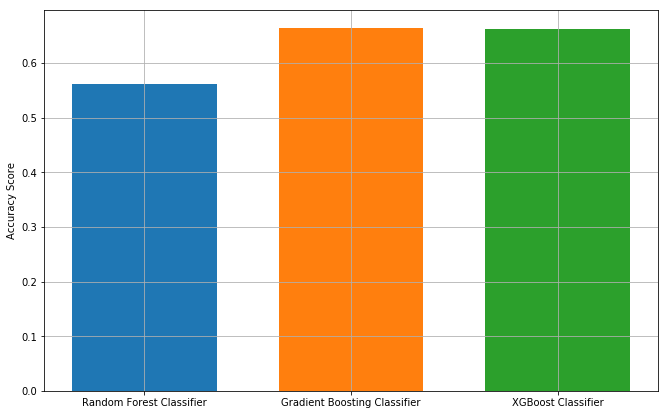

In [44]:
class_names = ['Random Forest Classifier', 'Gradient Boosting Classifier', 'XGBoost Classifier']
class_values = [rf_acc, gbr_acc, xgb_acc]

plt.rcParams['figure.figsize'] = (11,7)
plt.grid()
plt.ylabel('Accuracy Score')
for i in range(len(class_names)):
    print("The result for the " + str(class_names[i]) + " is: " + str(class_values[i]))
    plt.bar(class_names[i], class_values[i], width=0.7)
plt.show()

# Conclusions
    Although the Gradient Boosting ended as the best one of the three algorithms tested the difference 
    was not that big. With an accuracy of 66% (66.32), the Gradient Boosting surpassed the XGBoost only 
    for 0,0013%.
    
## What can be improved?